In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from benchmark_mae.evaluate import edge_roc_curve
from rhapsody.util import rank_hits
from itertools import product
from skbio.stats.composition import clr, centralize
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from benchmark_mae.generators import ground_truth_edges
from benchmark_mae.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
import yaml
%matplotlib inline

In [2]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])

In [3]:
!ls ../../results/depth_benchmark

deep_mae.0_a.results           sampleids
deep_mae.1_a.results           spearman.0_a.results
depth_params11.yaml            spearman.1_a.results
edges.0_a.txt                  table.abs.metabolites.0_a.biom
edges.1_a.txt                  table.abs.metabolites.1_a.biom
logdir_180924_215509           table.abs.microbes.0_a.biom
logdir_180924_215510           table.abs.microbes.1_a.biom
logdir_180924_215522           table.rel.metabolites.0_a.biom
metadata.0_a.txt               table.rel.metabolites.1_a.biom
metadata.1_a.txt               table.rel.microbes.0_a.biom
pearson.0_a.results            table.rel.microbes.1_a.biom
pearson.1_a.results


In [4]:
results_dir = '../../results/effect_size_benchmark/'
with open('%s/test_effect_params15.yaml' % results_dir, 'r') as f:
    effect_params = yaml.load(f)

#results_dir = '../../results/depth_benchmark/'
#with open('%s/depth_params11.yaml' % results_dir, 'r') as f:
#    effect_params = yaml.load(f)

kmax=250
sample_id = -1
mode = '.rel'

sample_ids = effect_params['samples']
modes = effect_params['modes']
tools = ['deep_mae', 'pearson', 'spearman']

In [5]:
ids = list(product(tools, modes, sample_ids))
fnames = list(map(lambda x: '.'.join(x) + '.results', ids))

In [6]:
df = pd.DataFrame(ids, index=fnames, columns=['tools', 'modes', 'samples'])

Deep learning ranks

In [7]:
sample = sample_ids[sample_id] 
tool = tools[0]
r_fname = 'deep_mae%s.%s.results' % (mode, sample)
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0)

In [8]:
metabolites = load_table(
    os.path.join(results_dir, 'table.rel.metabolites.%s.biom' % sample)
).to_dataframe().T

microbes = load_table(
    os.path.join(results_dir, 'table.rel.microbes.%s.biom' % sample)
).to_dataframe().T

edges = ground_truth_edges(microbes, metabolites)

In [9]:
mae_pos, mae_neg = _edge_roc_curve(rel_ranks, edges, axis=1, k_max=kmax)

In [10]:
mae_pos['TPR'] = mae_pos.apply(sensitivity, axis=1)
mae_pos['TNR'] = mae_pos.apply(specificity, axis=1)

Spearman

In [11]:
sample = sample_ids[sample_id] 
tool = tools[0]
r_fname = 'spearman%s.%s.results' % (mode, sample)
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0)

In [12]:
spear_pos, spear_neg = _edge_roc_curve(rel_ranks, edges, k_max=kmax)

In [13]:
spear_pos['TPR'] = spear_pos.apply(sensitivity, axis=1)
spear_pos['TNR'] = spear_pos.apply(specificity, axis=1)

Pearson

In [14]:
sample = sample_ids[sample_id] 
tool = tools[0]
r_fname = 'pearson%s.%s.results' % (mode, sample)
edge_file = '%s/edges.%s.txt' % (results_dir, sample)

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0)

In [15]:
pear_pos, pear_neg = _edge_roc_curve(rel_ranks, edges, k_max=kmax)

In [16]:
pear_pos['TPR'] = pear_pos.apply(sensitivity, axis=1)
pear_pos['TNR'] = pear_pos.apply(specificity, axis=1)

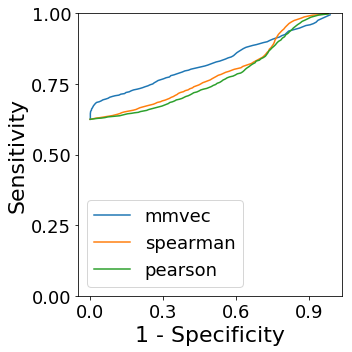

In [17]:
fontsize = 22
labelsize = 18

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(1-mae_pos['TPR'], mae_pos['TNR'], label='mmvec')
ax.plot(1-spear_pos['TPR'], spear_pos['TNR'], label='spearman')
ax.plot(1-pear_pos['TPR'], pear_pos['TNR'], label='pearson')
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.legend(prop={'size': 18})
ax.set_xlabel('1 - Specificity', fontsize=fontsize) 
ax.set_ylabel('Sensitivity', fontsize=fontsize)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.ylim([0, 1])
plt.tight_layout()
fig.savefig('../../figures/figure3/depth_roc.png')
fig.savefig('../../figures/figure3/depth_roc.pdf')